In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

Checking random Sample Audio from dataset

In [86]:
filename = 'UrbanSound8K\Dog_sound.wav'

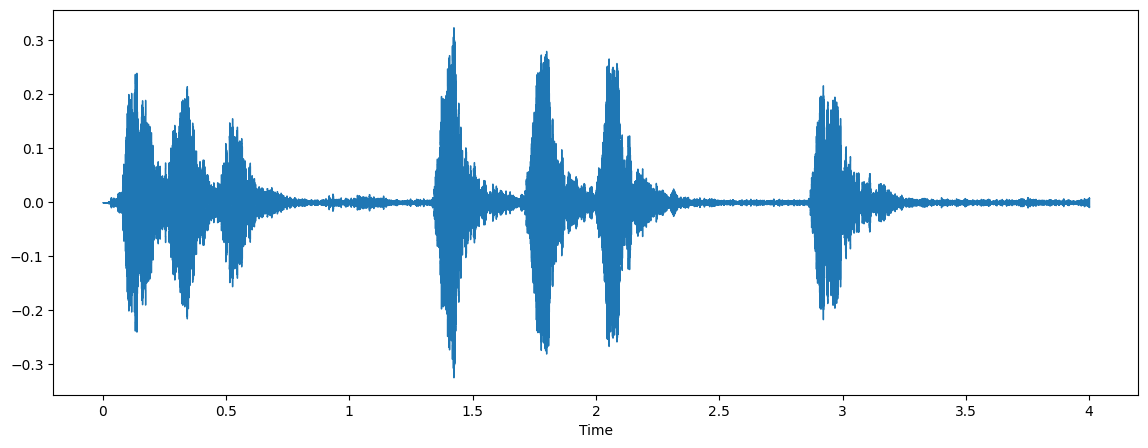

In [87]:
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr = sample_rate)
ipd.Audio(filename)

In [88]:
audio_file_path = 'UrbanSound8K\\Noise.wav'
audio_data, audio_sample_rate = librosa.load(audio_file_path)

In [89]:
print(audio_data)

[ 0.00331575  0.00467553  0.00361099 ... -0.00376796 -0.00347471
 -0.00357828]


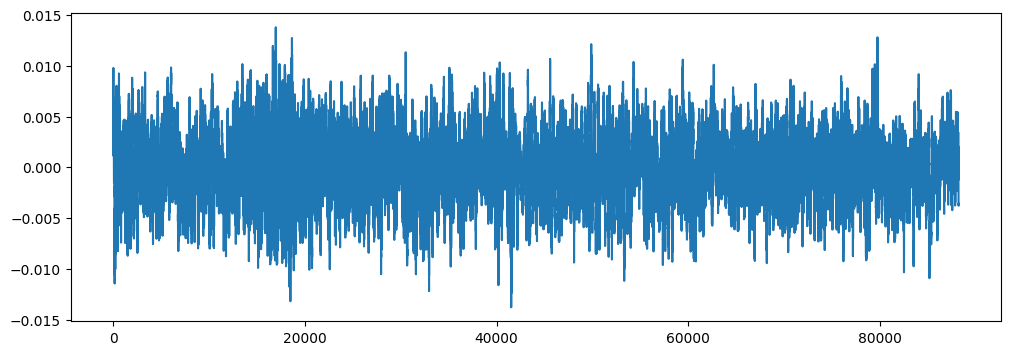

In [90]:
# Librosa normalized to the range [-1, 1].
plt.figure(figsize=(12,4))
plt.plot(audio_data)

In [91]:
from scipy.io import wavfile as wav
wave_samples, wave_audio = wav.read(audio_file_path)
wave_audio

array([[ 194,  100],
       [ 179,  113],
       [ 160,  124],
       ...,
       [-143,  -87],
       [-134,  -91],
       [-110,  -98]], dtype=int16)

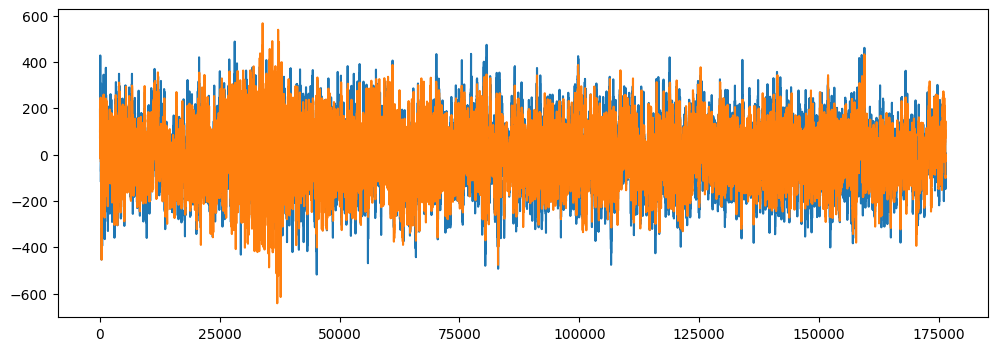

In [92]:
# Ploting streo chanells
plt.figure(figsize=(12,4))
plt.plot(wave_audio)

#### Load Data

In [95]:
import os 
audio_dataset_path = ('C:\\Projects\\DL Audio Classification Project\\UrbanSound8K\\audio\\')
metadata = pd.read_csv(r'C:\Projects\DL Audio Classification Project\UrbanSound8K\metadata\UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [96]:
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

Feature Extraction

In [97]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features
    

In [98]:
from tqdm import tqdm
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3554it [04:35, 12.51it/s]c:\Users\Asus Vivobook\AppData\Local\Programs\Python\Python38\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8325it [10:41, 16.58it/s]c:\Users\Asus Vivobook\AppData\Local\Programs\Python\Python38\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\Asus Vivobook\AppData\Local\Programs\Python\Python38\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [11:11, 13.01it/s]


In [99]:
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.52066, 52.00812, -...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036354, ...",children_playing
4,"[-446.60352, 113.68541, -52.402214, 60.302044,...",children_playing


In [100]:
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [101]:
X.shape

(8732, 40)

In [102]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

##### Label Encoding

In [103]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [104]:
y.shape

(8732, 10)

Train Test Split

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
X_train.shape

(6985, 40)

In [107]:
X_test.shape

(1747, 40)

In [108]:
y_train.shape

(6985, 10)

In [109]:
y_test.shape

(1747, 10)

#### Model creation

In [110]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [111]:
# No pf classes
num_labels = y.shape[1]

In [112]:
model = Sequential()
# 1st layer
model.add(Dense(100, input_shape = (40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 2nd layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 3rd layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [113]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               4100      
                                                                 
 activation_8 (Activation)   (None, 100)               0         
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 200)               20200     
                                                                 
 activation_9 (Activation)   (None, 200)               0         
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 100)              

In [114]:
model.compile(loss='categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'adam')

In [115]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
batch_size = 32

checkpoint = ModelCheckpoint(filepath= 'saved_models/audio_classification.hdf5', verbose=1, save_best_only=True)

start = datetime.now()

model.fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpoint], verbose=1)

duration = datetime.now()-start
print('Training completed in time:', duration)


Epoch 1/100


204/219 [==========================>...] - ETA: 0s - loss: 11.0677 - accuracy: 0.1239
Epoch 1: val_loss improved from inf to 2.28520, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 2s 5ms/step - loss: 10.5451 - accuracy: 0.1228 - val_loss: 2.2852 - val_accuracy: 0.1208
Epoch 2/100
 31/219 [===>..........................] - ETA: 0s - loss: 2.7467 - accuracy: 0.1371

c:\Users\Asus Vivobook\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


209/219 [===========================>..] - ETA: 0s - loss: 2.5296 - accuracy: 0.1293
Epoch 2: val_loss improved from 2.28520 to 2.26109, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 2.5205 - accuracy: 0.1294 - val_loss: 2.2611 - val_accuracy: 0.1328
Epoch 3/100
219/219 [==============================] - ETA: 0s - loss: 2.2999 - accuracy: 0.1553
Epoch 3: val_loss improved from 2.26109 to 2.15783, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 2.2999 - accuracy: 0.1553 - val_loss: 2.1578 - val_accuracy: 0.1803
Epoch 4/100
214/219 [============================>.] - ETA: 0s - loss: 2.2208 - accuracy: 0.1790
Epoch 4: val_loss improved from 2.15783 to 2.10125, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 2.2196 - accuracy: 0.1792 - val_loss: 2.1013 - val_accuracy: 0.2026
Epoch 5

In [116]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy[1])

0.7653119564056396


#### Testing Some Test Audio Data

In [117]:
test_filename = 'UrbanSound8K\Siren.wav'
audio, sample_rate = librosa.load(test_filename, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr = sample_rate,n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)

print(mfccs_scaled_features)
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
print(prediction_class)

[-214.24966      81.41967     -34.20862       1.161337    -28.110138
    3.8415809     5.788872     30.685637      0.40277368   -3.9493642
  -22.504978     -5.741534      3.4944644    15.234962     -4.265269
   -4.9671216    -9.430968     -9.310977     -2.9685073    17.53531
   11.54546      -4.390493     -9.133173     -5.963332     -6.4121723
   -5.77174      -4.612545     -2.65665      -6.208589     -3.2002072
    2.1734707    -2.7543144   -11.283181    -10.861946     -7.3216534
    1.7102717     8.796146     11.332902     -5.6202626   -16.981203  ]
[[-214.24966      81.41967     -34.20862       1.161337    -28.110138
     3.8415809     5.788872     30.685637      0.40277368   -3.9493642
   -22.504978     -5.741534      3.4944644    15.234962     -4.265269
    -4.9671216    -9.430968     -9.310977     -2.9685073    17.53531
    11.54546      -4.390493     -9.133173     -5.963332     -6.4121723
    -5.77174      -4.612545     -2.65665      -6.208589     -3.2002072
     2.1734707    -2

In [118]:
ipd.Audio(test_filename)

#### Model successfully recognises audio as Siren. 